In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-ratings/ratings_Beauty.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("/kaggle/input/amazon-ratings/ratings_Beauty.csv")
df.shape

(2023070, 4)

In [4]:
df['UserId'] = df['UserId'].astype('category')
df['ProductId'] = df['ProductId'].astype('category')

df['UserId'] = df['UserId'].cat.codes
df['ProductId'] = df['ProductId'].cat.codes

num_users = df['UserId'].nunique()
num_items = df['ProductId'].nunique()

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [6]:
class CollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=64):
        super(CollaborativeFiltering, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.item_embeddings = nn.Embedding(num_items, embedding_size)

    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        item_embedding = self.item_embeddings(item)
        score = torch.bmm(user_embedding.unsqueeze(1), item_embedding.unsqueeze(2)).squeeze() # result : 1*64 ** 64**1 for each batch_size
        return score

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = CollaborativeFiltering(num_users, num_items).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

cuda


In [8]:
batch_size = 32

train_users = torch.LongTensor(train_df['UserId'].values)
train_items = torch.LongTensor(train_df['ProductId'].values)
train_ratings = torch.FloatTensor(train_df['Rating'].values)

test_users = torch.LongTensor(test_df['UserId'].values).to(device)
test_items = torch.LongTensor(test_df['ProductId'].values).to(device)
test_ratings = torch.FloatTensor(test_df['Rating'].values).to(device)

train_dataset = TensorDataset(train_users, train_items, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
num_epochs = 15
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0

    model.train()
    for batch in train_loader:
        user, item, rating = [x.to(device) for x in batch]
        pred = model(user, item).squeeze()
        loss = criterion(pred, rating)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss/len(train_loader))
    print(f"Epoch {epoch+1} MSE Loss: {train_losses[-1]}")

    model.eval() 
    with torch.no_grad():
        pred_test_ratings = model(test_users, test_items)
        test_loss = criterion(pred_test_ratings, test_ratings)
        
    test_losses.append(test_loss.item())
    print(f'Test MSE Loss: {test_losses[-1]}')

  7%|▋         | 1/15 [29:10<6:48:23, 1750.23s/it]

Epoch 1 MSE Loss: 76.53632240477181
Test MSE Loss: 71.40094757080078


 13%|█▎        | 2/15 [58:33<6:20:52, 1757.89s/it]

Epoch 2 MSE Loss: 40.95103639760334
Test MSE Loss: 66.9437255859375


 20%|██        | 3/15 [1:27:57<5:52:06, 1760.50s/it]

Epoch 3 MSE Loss: 22.60410848552369
Test MSE Loss: 65.53408813476562


 27%|██▋       | 4/15 [1:57:20<5:22:56, 1761.54s/it]

Epoch 4 MSE Loss: 12.797441052749875
Test MSE Loss: 65.34053802490234


 33%|███▎      | 5/15 [2:26:44<4:53:44, 1762.44s/it]

Epoch 5 MSE Loss: 7.553579787935352
Test MSE Loss: 65.43719482421875


 40%|████      | 6/15 [2:56:07<4:24:25, 1762.84s/it]

Epoch 6 MSE Loss: 4.824991311950517
Test MSE Loss: 65.48780059814453


 47%|████▋     | 7/15 [3:25:31<3:55:03, 1762.97s/it]

Epoch 7 MSE Loss: 3.4539550991672296
Test MSE Loss: 65.36870574951172


 53%|█████▎    | 8/15 [3:54:53<3:25:40, 1762.93s/it]

Epoch 8 MSE Loss: 2.7726167599923466
Test MSE Loss: 65.1078872680664


 60%|██████    | 9/15 [4:24:02<2:55:50, 1758.34s/it]

Epoch 9 MSE Loss: 2.440092732121842
Test MSE Loss: 64.75260162353516


 67%|██████▋   | 10/15 [4:52:56<2:25:54, 1750.88s/it]

Epoch 10 MSE Loss: 2.2658133679683408
Test MSE Loss: 64.30743408203125


 73%|███████▎  | 11/15 [5:21:51<1:56:24, 1746.01s/it]

Epoch 11 MSE Loss: 2.175674700660633
Test MSE Loss: 63.875465393066406


 80%|████████  | 12/15 [5:50:48<1:27:09, 1743.21s/it]

Epoch 12 MSE Loss: 2.115840631295493
Test MSE Loss: 63.38216781616211


 87%|████████▋ | 13/15 [6:19:42<58:01, 1740.56s/it]  

Epoch 13 MSE Loss: 2.079161570981358
Test MSE Loss: 62.92597961425781


 93%|█████████▎| 14/15 [6:48:37<28:58, 1738.82s/it]

Epoch 14 MSE Loss: 2.0501423119287168
Test MSE Loss: 62.46090316772461


100%|██████████| 15/15 [7:17:32<00:00, 1750.14s/it]

Epoch 15 MSE Loss: 2.030732111157096
Test MSE Loss: 61.9972038269043


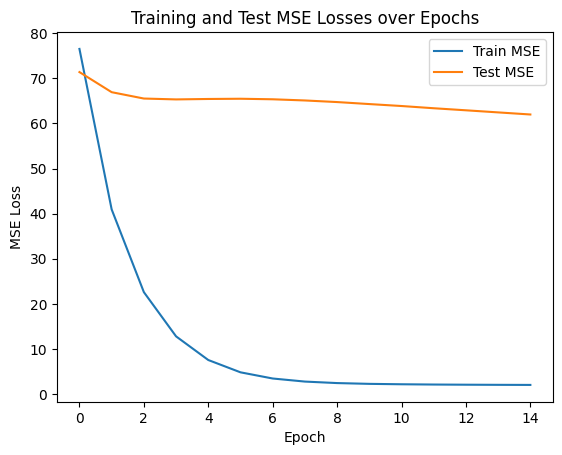

In [10]:
plt.plot(range(num_epochs), train_losses, label='Train MSE')
plt.plot(range(num_epochs), test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test MSE Losses over Epochs')
plt.legend()
plt.show();

In [11]:
torch.save(model.state_dict(), 'model.pth')

In [12]:
def get_recommendations(user_id, num_recommendations=10):

    item_tensor = torch.LongTensor(np.arange(num_items))
    user_tensor = torch.full_like(item_tensor, user_id)
    
    with torch.no_grad():
        pred_ratings = model(user_tensor, item_tensor).numpy()
    
    top_items = np.argsort(-pred_ratings)[:num_recommendations]
    
    return top_items

In [13]:
top_items = get_recommendations(0)
print("Top 10 recommended items for user 0:", top_items)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)